<h1>Handwriting Letter GAN</h1>

<h3>Links</h3>
<ul>
    <li><a href=https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/>cGAN Code</a></li>
    <li><a href=https://keras.io/getting-started/functional-api-guide/>Keras Functional API</a></li>
    <li><a href=<li><a href=https://arxiv.org/pdf/1702.05373.pdf>EMNIST Dataset Paper</a></li>
</ul>

In [ ]:
!pip install emnist
!pip install python-archive
!pip install -U scipy==1.2.0

import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from emnist import *
from skimage import data, io, transform
import matplotlib.pyplot as plt

from archive import Archive
from archive import extract
from os import listdir
from os.path import isfile, join
from __future__ import print_function
import pandas as pd
import cv2
from scipy.misc import imresize, imrotate, imsave

  Created wheel for python-archive: filename=python_archive-0.2-cp36-none-any.whl size=6473 sha256=a8fbcb5b099a258a351fd838611a251b6218bc5ea74bfa650f3dc5bd7d4eecd9
  Stored in directory: /root/.cache/pip/wheels/3a/3b/c2/cde06bb709d37d647cc99a812cc1a06f2704d5feb20e97fee6
Successfully built python-archive
     |████████████████████████████████| 26.6MB 119kB/s 
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.2.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!wget https://s3-eu-west-1.amazonaws.com/handwriting-curated-database/curated.tar.gz
extract('curated.tar.gz', 'curated_data')

# display plots in this notebook
%matplotlib inline

path = 'curated_data'

character_curated = [ord(c) for c in '.,!?']

punc_images = []
punc_labels = []
for ind in range(len(character_curated)):
    i = character_curated[ind]
    path_img = path + '/curated/' + str(i) + '/'
    for file_name in [f for f in listdir(path_img) if isfile(join(path_img, f))]:
        img = cv2.imread(path_img + file_name, 0)
        img = cv2.resize(img, (28, 28), interpolation = cv2.INTER_AREA)
        punc_images += [img]
        punc_labels += [ind + 62]
    
plt.imshow(punc_images[0])
print(punc_labels[0])

--2020-07-03 08:06:58--  https://s3-eu-west-1.amazonaws.com/handwriting-curated-database/curated.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.96.242
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.96.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30058219 (29M) [application/x-gzip]
Saving to: ‘curated.tar.gz’

curated.tar.gz      100%[===================>]  28.67M  90.6MB/s    in 0.3s    

2020-07-03 08:06:58 (90.6 MB/s) - ‘curated.tar.gz’ saved [30058219/30058219]



In [ ]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

(697932, 28, 28) (697932,)
(32207, 28, 28) (32207,)
0


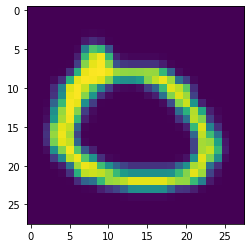

In [ ]:
images, labels = extract_training_samples('byclass')
print(images.shape, labels.shape)

# reduce the number of images per class
im, la = [], []
for c in range(62):
  lc = np.where(labels==c)[0] # index of label of that class
  # print(len(lc))
  imc, lac = images[lc][:500], labels[lc][:500] # min images per class = 1896
  im.extend(imc)
  la.extend(lac)
  # print(len(im), len(la))

im.extend(punc_images)
la.extend(punc_labels)

images, labels = np.asarray(im), np.asarray(la)

print(images.shape, labels.shape)
plt.imshow(images[0])
print(labels[0])

In [ ]:
def define_discriminator(input_shape=(28, 28, 1), n_classes=66):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(input_shape[0] * input_shape[1])(emb)
    re_label_h = Reshape((input_shape[0], input_shape[1], 1))(label_h)
    # image input
    image_in = Input(shape=input_shape)
    # combine inputs
    merge = Concatenate()([image_in, re_label_h])
    # convnet
    h1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(h1)
    h2 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(h2)
    # fully connected net
    fl = Flatten()(r2) 
    dr = Dropout(0.4)(fl)
    # output
    out = Dense(1, activation='sigmoid')(dr)
    # define and compile model
    model = Model([image_in, label_in], out)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
def define_generator(latent_dim, n_classes=66):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(7*7)(emb)
    re_label_h = Reshape((7, 7, 1))(label_h)
    # noisy image input
    noise_in = Input(shape=(latent_dim,))
    noise_h = Dense(128*7*7)(noise_in)
    noise_r = LeakyReLU(alpha=0.2)(noise_h)
    re_noise_r = Reshape((7, 7, 128))(noise_r)
    # combine inputs
    merge = Concatenate()([re_noise_r, re_label_h])
    # upsampling
    u1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(u1)
    u2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(u2)
    # output
    out = Conv2D(1, (7, 7), activation='tanh', padding='same')(r2)
    # define model
    model = Model([noise_in, label_in], out)
    return model

In [ ]:
def define_gan(gen, dis):
    # discriminator shouldn't be trainable
    dis.trainable = False
    # get generator inputs and outputs
    gen_noise, gen_label = gen.input
    gen_output = gen.output
    # feed to discriminator
    gan_output = dis([gen_output, gen_label])
    # define and compile GAN model
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
def prepare_inputs(images, labels):
    if len(images.shape) > 2:
      images = np.squeeze(images)
    X = np.expand_dims(images, axis=-1)
    X = X.astype('float32')
    X = (X-127.5) / 127.5
    return [X, labels]
    
def generate_real_samples(images, labels, n_samples):
    rand_index = randint(0, images.shape[0], n_samples)
    X, labels = images[rand_index], labels[rand_index]
    y = np.ones((n_samples, 1)) * 0.9 # discriminator target label
    # label smoothing
    #ind = np.random.choice(list(range(len(y))), size=int(len(y) * 0.01), replace=False)
    #y[ind] = 1-y[ind]
    return [X, labels], y

def generate_latent_noise(latent_dim, n_samples, n_classes=66):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

def generate_fake_samples(gen, latent_dim, n_samples):
    zin, lin = generate_latent_noise(latent_dim, n_samples)
    images = gen.predict([zin, lin])
    y = np.zeros((n_samples, 1))  # discriminator target label
    # label smoothing
    #ind = np.random.choice(list(range(len(y))), size=int(len(y) * 0.01), replace=False)
    #y[ind] = 1-y[ind]
    return [images, lin], y

In [ ]:
def train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=100, batch_size=128):
    batch_per_epoch = int(images.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    losses = [[0] * 3 for _ in range(n_epochs)]

    # enumerate epochs
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # train discriminator on real images
            [X_real, labels_real], y_real = generate_real_samples(images, labels, half_batch)
            d_loss1, _ = dis.train_on_batch([X_real, labels_real], y_real)
            # train discriminator on generated images
            [X_fake, labels_fake], y_fake = generate_fake_samples(gen, latent_dim, half_batch)
            #d_loss2 = dis.evaluate([X_fake, labels_fake], y_fake)[0]
            #if d_loss2 > 0.5:
            d_loss2, _ = dis.train_on_batch([X_fake, labels_fake], y_fake)
            # prepare generator input
            [zin, label_in] = generate_latent_noise(latent_dim, batch_size)
            # invert labels for fake samples (prevent vanishing gradients)
            y_gan = np.ones((batch_size, 1))
            # label smoothing
            #ind = np.random.choice(list(range(len(y_gan))), size=int(len(y_gan) * 0.01), replace=False)
            #y_gan[ind] = 1-y_gan[ind]
            # update generator loss
            for _ in range(1):
              g_loss = gan_model.train_on_batch([zin, label_in], y_gan)
            # output losses
            if j % 50 == 0:
              print('Epoch {}, batch {}/{}:\tDiscriminator: real loss {}, fake loss {}\tGenerator: loss {}'
                  .format(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
        losses[i] = [d_loss1, d_loss2, g_loss]
    # save the models
    gen.save('generator.h5')
    dis.save('discriminator.h5')
    gan_model.save('gan.h5')

    return losses    

In [ ]:
latent_dim = 100
images, labels = prepare_inputs(images, labels)
print(images.shape, labels.shape)
dis = define_discriminator()
gen = define_generator(latent_dim)
gan_model = define_gan(gen, dis)
print("\nDiscriminator\n")
dis.summary()
print("\nGenerator\n")
gen.summary()
print("\nGAN\n")
gan_model.summary()

from tensorflow.keras.utils import plot_model
from google.colab import files
plot_model(gan_model, to_file='char_gan.png', show_shapes=True)
files.download('char_gan.png')

(32207, 28, 28, 1) (32207,)

Discriminator

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        3300        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________

In [ ]:
losses = train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=50, batch_size=128)

Epoch 1, batch 1/251:	Discriminator: real loss 0.15995699167251587, fake loss 0.25040119886398315	Generator: loss 0.6927260756492615
Epoch 1, batch 51/251:	Discriminator: real loss 0.05935955047607422, fake loss 0.022291703149676323	Generator: loss 1.9859470129013062
Epoch 1, batch 101/251:	Discriminator: real loss 0.05503878742456436, fake loss 0.0074484385550022125	Generator: loss 2.552060127258301
Epoch 1, batch 151/251:	Discriminator: real loss 0.03320116549730301, fake loss 0.006888682022690773	Generator: loss 2.8008971214294434
Epoch 1, batch 201/251:	Discriminator: real loss 0.03004736825823784, fake loss 0.003523685038089752	Generator: loss 2.969562530517578
Epoch 1, batch 251/251:	Discriminator: real loss 0.020732905715703964, fake loss 0.00991649180650711	Generator: loss 3.487943172454834
Epoch 2, batch 1/251:	Discriminator: real loss 0.029133707284927368, fake loss 0.006273622624576092	Generator: loss 3.4953954219818115
Epoch 2, batch 51/251:	Discriminator: real loss 0.01550

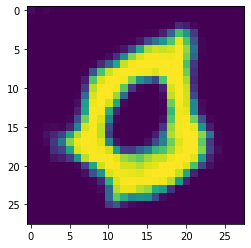

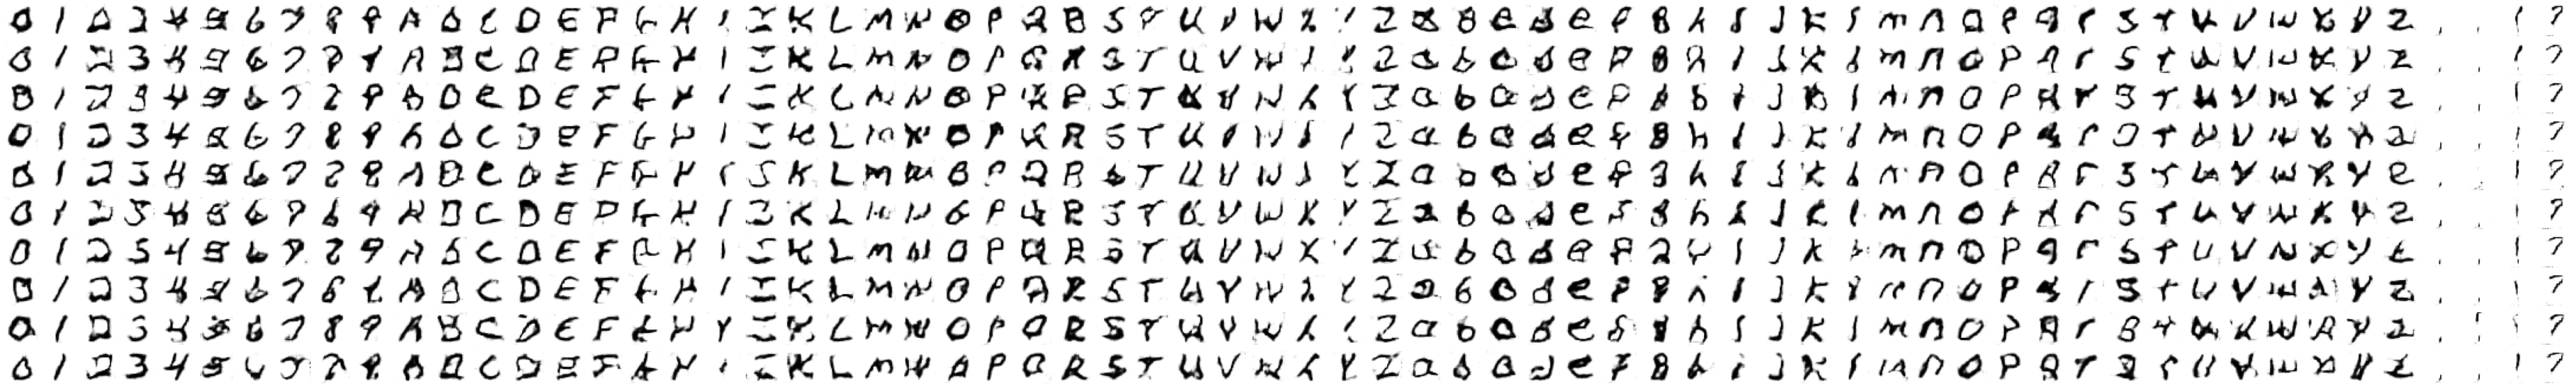

In [ ]:
def show_generated(examples, n, c):
  fig = plt.figure(figsize=(c, n))
  for i in range(n*c):
    img = fig.add_subplot(n, c, i+1)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0], cmap='gray_r')
  plt.show()

n = 10
c = 66

model = load_model('generator.h5')
noise, _ = generate_latent_noise(latent_dim, n*c)
labs = np.asarray([x for _ in range(n) for x in range(c)])

X = model.predict([noise, labs])
# scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
x = np.squeeze(X[0])
plt.imshow(x)

show_generated(X, n, c)

In [ ]:
from google.colab import files

dflag = False
if dflag:
  #files.download('gan.h5')
  files.download('generator.h5')
  #files.download('discriminator.h5')

[[0.020732905715703964, 0.00991649180650711, 3.487943172454834], [0.01558117289096117, 0.013394887559115887, 3.9567723274230957], [0.007519054226577282, 0.00019415895803831518, 6.445366382598877], [0.1848214566707611, 0.20924580097198486, 0.9006109237670898], [0.19820597767829895, 0.1984063982963562, 0.8450461030006409], [0.20934346318244934, 0.20789414644241333, 0.8482829332351685], [0.2023518979549408, 0.20012490451335907, 0.826491117477417], [0.2030048966407776, 0.19770701229572296, 0.8825838565826416], [0.1980152428150177, 0.20232529938220978, 0.8508448004722595], [0.19012056291103363, 0.19974760711193085, 0.8579826951026917], [0.20355257391929626, 0.20277753472328186, 0.887604296207428], [0.19538597762584686, 0.19863514602184296, 0.8763440251350403], [0.19270364940166473, 0.18966172635555267, 0.8425329327583313], [0.18991580605506897, 0.19781523942947388, 0.8948367834091187], [0.18761512637138367, 0.20094376802444458, 0.8885821104049683], [0.18839310109615326, 0.19014596939086914,

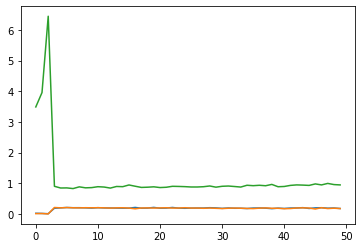

In [ ]:
print(losses)
plt.plot(losses)
np.savetxt('losses.csv', losses, delimiter=',')
files.download('losses.csv')